In [1]:
from interarray.importer import load_repository
from interarray.svg import svgplot
from interarray.mesh import make_planar_embedding
from interarray.interarraylib import G_from_S
from interarray.heuristics import EW_presolver
from interarray.MILP import pyomo as omo
from interarray.pathfinding import PathFinder

In [2]:
from pyomo import environ as pyo

## Initialize MILP solver

In [3]:
sciper = pyo.SolverFactory('scip')
sciper.available(), type(sciper)

(True, pyomo.solvers.plugins.solvers.SCIPAMPL.SCIPAMPL)

## Load interarray's locations

In [4]:
locations = load_repository()

## Optimize Sheringham Shoal

In [5]:
L = locations.sheringham
capacity = 6

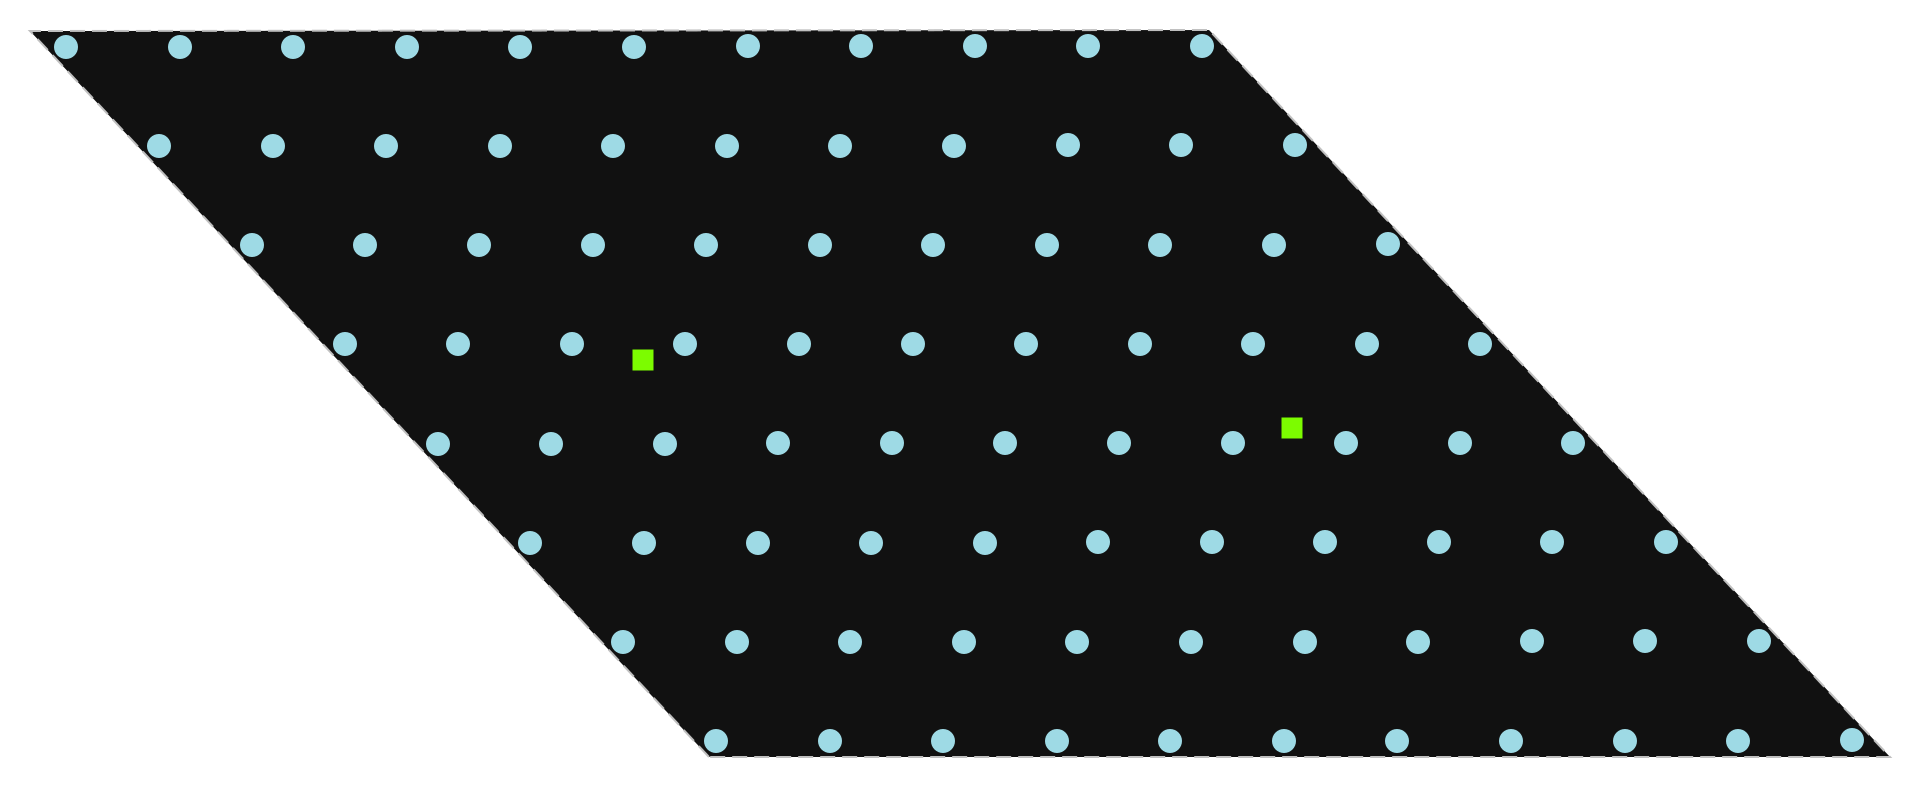

In [6]:
svgplot(L)

In [7]:
P, A = make_planar_embedding(L)

Initial heuristic solution to warm-start the solver:

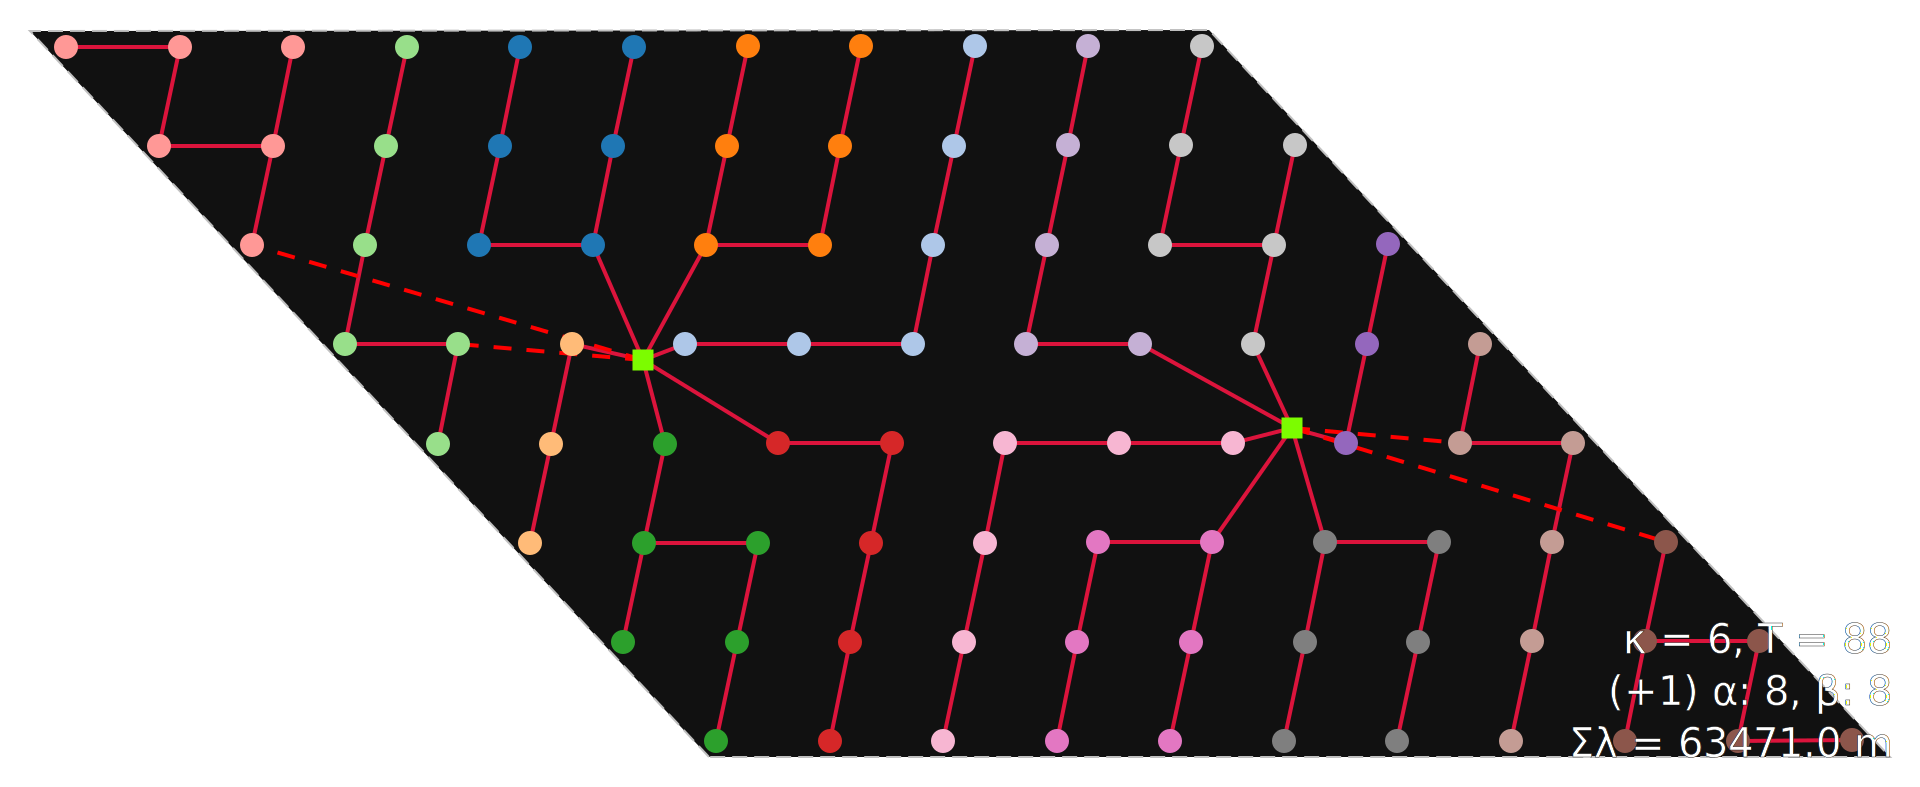

In [8]:
Sʹ = EW_presolver(A, capacity=capacity)
Gʹ = G_from_S(Sʹ, A)
svgplot(Gʹ)

In [9]:
model = omo.make_min_length_model(
    A, capacity,
    gateXings_constraint=False,
    branching=True,
    gates_limit=False
)
omo.warmup_model(model, Sʹ);

In [10]:
sciper.options.update({
    'limits/gap': 0.005,
    'limits/time': 180.,
    'display/freq': 0.5,
    # this is currently useless, as pyomo is not calling the concurrent solver
    'parallel/maxnthreads': 16,
})

In [11]:
result = sciper.solve(model, tee=True)

SCIP version 9.2.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: Soplex 7.1.3] [GitHash: 0d2d3c7c2d]
Copyright (c) 2002-2025 Zuse Institute Berlin (ZIB)

External libraries: 
  Soplex 7.1.3         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 60fd96f2]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (github.com/coin-or/CppAD)
  ZLIB 1.3.1           General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.3.0            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.6.2          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  AMPL/MP 690e9e7      AMPL .nl file reader library (github.com/ampl/mp)
  PaPILO 2.4.1         parallel presolve for integer and linear optimization (github.com/scipopt/papilo) (built with TBB) [GitHash: 11974394]
  Nauty 2.8.8          Computing Graph Automor

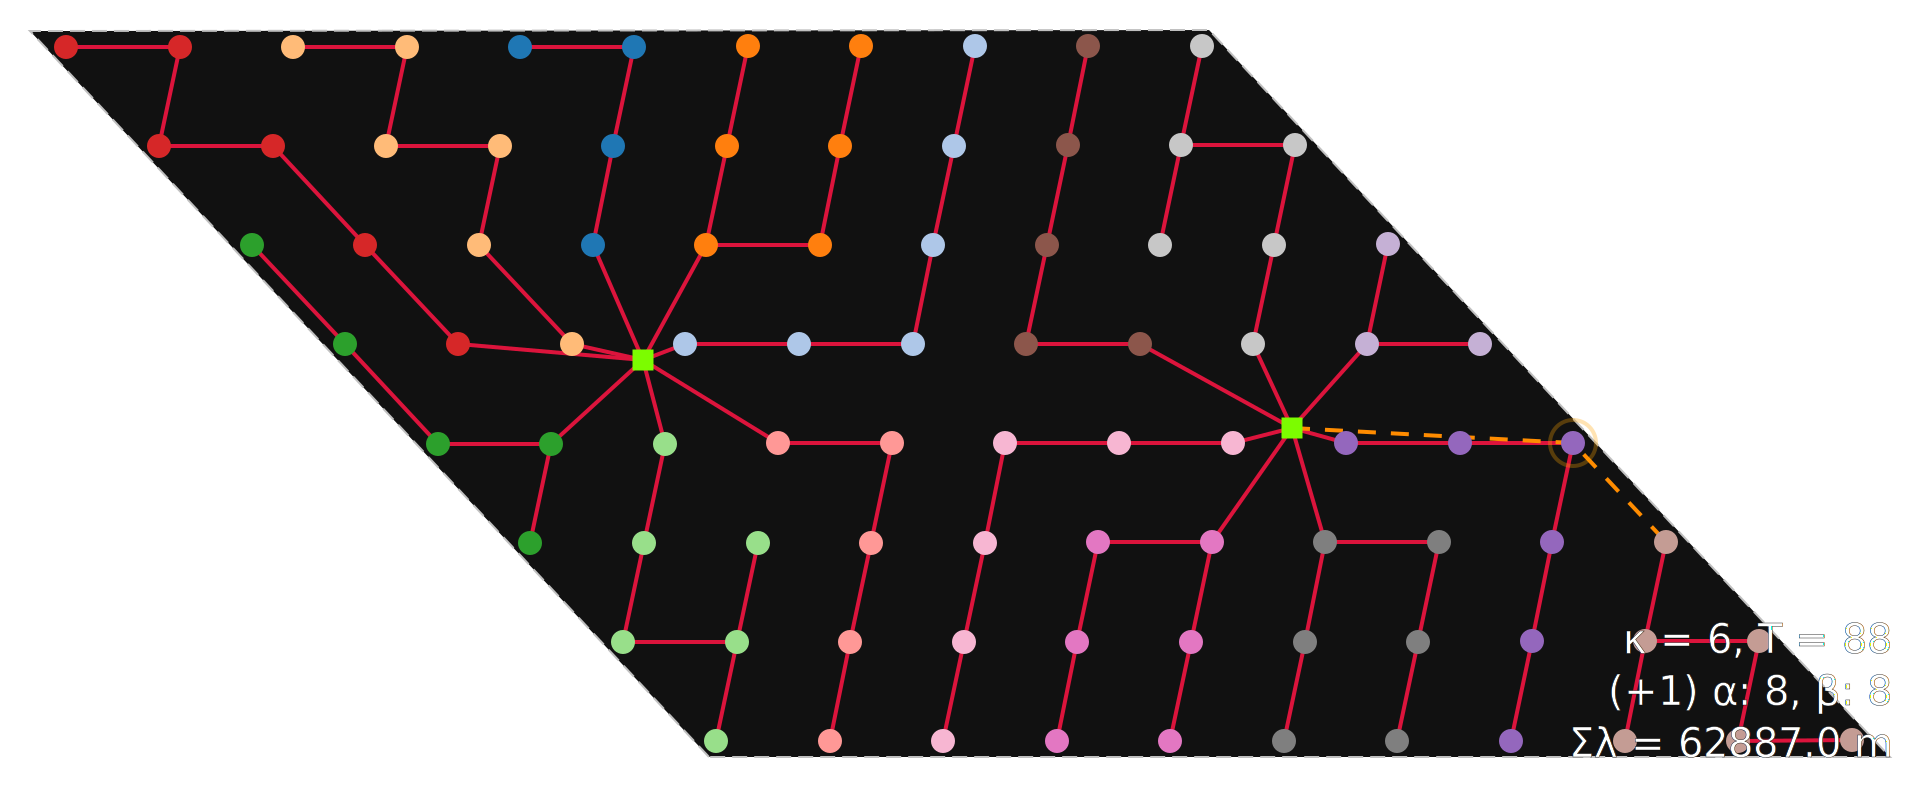

In [12]:
S = omo.S_from_solution(model, sciper, result)
G = G_from_S(S, A)
H = PathFinder(G, planar=P, A=A).create_detours()
svgplot(H)